 In this notebook I train a Gaussian Naive Bayes model to predict which class [quarry blast, earthquake, or MIS] an event belongs to based on 12 features computed by Keith and Relu.

In [1]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
train_df = pd.read_csv("../data/train.2024.04.16.csv")
test_df = pd.read_csv("../data/test.2024.04.16.csv")
classes = ['ex', 'eq', 'mis']

In [3]:
feature_col_names = ['F01', 'F04', 'F06', 'F09','F13']

In [4]:
train_all_feats_df = train_df[~np.any(np.isnan(train_df[feature_col_names]), axis=1)]
X_train = train_all_feats_df[feature_col_names].to_numpy()
y_train = train_all_feats_df["y"].to_numpy()

In [5]:
test_all_feats_df = test_df[~np.any(np.isnan(test_df[feature_col_names]), axis=1)]
X_test = test_all_feats_df[feature_col_names].to_numpy()
y_test = test_all_feats_df["y"].to_numpy()

In [6]:
# Get all testing examples that have values for all 13 features
feature_col_all = ['F01', 'F02', 'F03', 'F04',
       'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'F13']
test_all_feats_df = test_df[~np.any(np.isnan(test_df[feature_col_all]), axis=1)]
X_test_all = test_all_feats_df[feature_col_names].to_numpy()
y_test_all = test_all_feats_df["y"].to_numpy()

In [7]:
def drop_inds(X, y, lb, ub):
    drop_inds = np.unique(np.concatenate([np.unique(np.where(X < lb)[0]), 
                                        np.unique(np.where(X > ub)[0])]))
    keep_inds = np.delete(np.arange(0, X.shape[0]), drop_inds)
    X = X[keep_inds, :]
    y = y[keep_inds]

    return X, y

In [8]:
# Remove examples with values beyond the outer fence of the training features
print(X_train.shape, X_test.shape, X_test_all.shape)
q1, q3  = np.percentile(X_train, [25, 75], axis=0)
IQR = q3 - q1
lower_fence = q1 - IQR*3.0
upper_fence = q3 + IQR*3.0
X_train, y_train = drop_inds(X_train, y_train, lower_fence, upper_fence)
X_test, y_test = drop_inds(X_test, y_test, lower_fence, upper_fence)
X_test_all, y_test_all = drop_inds(X_test_all, y_test_all, lower_fence, upper_fence)
print(X_train.shape, X_test.shape, X_test_all.shape)

(1364, 5) (328, 5) (207, 5)
(1360, 5) (327, 5) (206, 5)


In [9]:
print('Training:', X_train.shape, y_train.shape)
print('Testing:', X_test.shape, y_test.shape)
print('Training class percentage:', np.unique(y_train, return_counts=True)[1]/len(y_train))
print('Testing class percentage:', np.unique(y_test, return_counts=True)[1]/len(y_test))

Training: (1360, 5) (1360,)
Testing: (327, 5) (327,)
Training class percentage: [0.18161765 0.70367647 0.11470588]
Testing class percentage: [0.16819572 0.70948012 0.12232416]


In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_all_scaled = scaler.transform(X_test_all)

# Train a Gaussian Naive Bayes model

In [11]:
nb = GaussianNB()

In [12]:
nb.fit(X_train_scaled, y_train)

GaussianNB()

In [13]:
y_pred_train = nb.predict(X_train_scaled)

In [14]:
cm = confusion_matrix(y_train, y_pred_train)
print(cm)

[[222   4  21]
 [ 25 932   0]
 [ 13   0 143]]


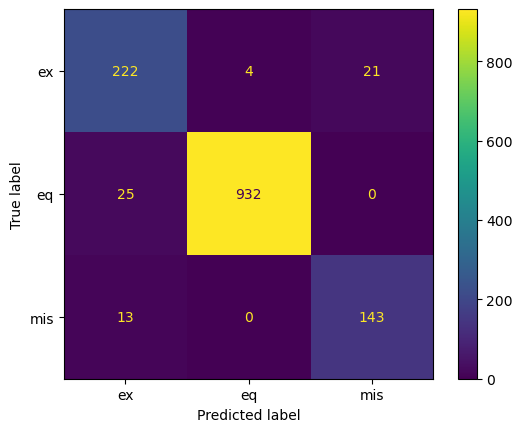

In [15]:
display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                       display_labels=classes)
display.plot()

In [16]:
f1_score(y_train, y_pred_train, average='macro')

0.9180566821498491

# Evaluate the GNB model on the testing set
Use F1 score - which is the harmonic mean of precision and recall. `averaging="macro"` means that the F1 score for each of the classes is simply averaged. I chose this because I care about all the classes equally and don't want to give more weight to eq.

In [17]:
y_pred_test = nb.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

[[ 52   2   1]
 [  7 225   0]
 [  6   0  34]]


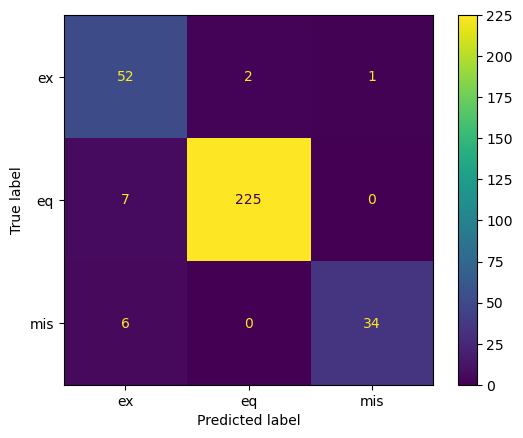

In [18]:
display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                       display_labels=classes)
display.plot()

In [19]:
f1_score(y_test, y_pred_test, average='macro')

0.9179084967320262

## NB testing results w/ 13 features

F1-score when training with all 13 features: 0.93

In [20]:
y_test_all_pred_nb = nb.predict(X_test_all_scaled)
cm = confusion_matrix(y_test_all, y_test_all_pred_nb)
print(cm)

[[ 32   2   1]
 [  1 142   0]
 [  3   0  25]]


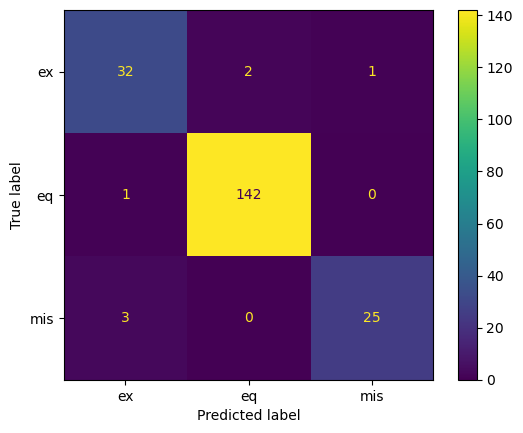

In [21]:
display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                       display_labels=['ex', 'eq', 'mis'])
display.plot()

In [22]:
f1_score(y_test_all, y_test_all_pred_nb, average='macro')

0.9389604716525591